In [148]:
# import noaa
import importlib
import noaa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime, timedelta, timezone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

sys.path.insert(0, os.path.abspath('../'))
from noaa import load_station_data, NOAAClient
# from stats import percent_NaN
importlib.reload(noaa)

<module 'noaa' from '/home/user/projects/data-mine-jlmedina/NOAA_climate_project/noaa.py'>

In [149]:
# checking if ipynb is using a different kernel?
print("Python:", sys.executable)
print("Kernel sees NOAA_TOKEN:", bool(os.environ.get("NOAA_TOKEN")))

Python: /home/user/projects/data-mine-jlmedina/NOAA_climate_project/.venv/bin/python
Kernel sees NOAA_TOKEN: False


In [150]:
df = load_station_data( "data/Ouray-stations-1.parquet")
print(df.head())
df.dtypes

         date datatype            station attributes  value
0  1982-05-15     PRCP  GHCND:USC00057020  T,,0,0730      0
1  1982-05-16     PRCP  GHCND:USC00057020   ,,0,0730      0
2  1982-05-17     PRCP  GHCND:USC00057020   ,,0,0730      0
3  1982-05-18     PRCP  GHCND:USC00057020   ,,0,0730      0
4  1982-05-19     PRCP  GHCND:USC00057020   ,,0,0730      0


date          object
datatype      object
station       object
attributes    object
value          int64
dtype: object

In [151]:
df.shape
#(22448, 5)
print(df.columns)

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')


Pivot datatype column into individual columns
    - likely use pivot() or pivot_tables() from pandas.
Attributes??
dtypes of df need to be not just generic objects?


In [152]:
print(df['datatype'].unique())
pivoted = df.pivot_table(index=["station","date"], columns="datatype", values="value").reset_index()    # pivots along the datatype column creating columns for each dtype.
    # creats a Hierarchical table, then flattens the table. 

# print(df.tail())
print(pivoted.head())
print(pivoted.tail())

['PRCP' 'WT03' 'SNOW' 'SNWD' 'WT05' 'TMAX' 'TMIN' 'TOBS' 'WT11' 'WT01'
 'WT04' 'DAPR' 'DASF' 'MDPR' 'MDSF' 'WESD' 'TAVG']
datatype            station        date  DAPR  DASF  MDPR  MDSF  PRCP  SNOW  \
0         GHCND:USC00057020  1982-05-15   NaN   NaN   NaN   NaN   0.0   NaN   
1         GHCND:USC00057020  1982-05-16   NaN   NaN   NaN   NaN   0.0   NaN   
2         GHCND:USC00057020  1982-05-17   NaN   NaN   NaN   NaN   0.0   NaN   
3         GHCND:USC00057020  1982-05-18   NaN   NaN   NaN   NaN   0.0   NaN   
4         GHCND:USC00057020  1982-05-19   NaN   NaN   NaN   NaN   0.0   NaN   

datatype  SNWD  TAVG  TMAX  TMIN  TOBS  WESD  WT01  WT03  WT04  WT05  WT11  
0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4          NaN   N

In [153]:
# some more descriptive stats..
print(pivoted.dtypes)
print(pivoted.shape)
print(pivoted.columns.tolist())
# print(df.columns.tolist())


datatype
station     object
date        object
DAPR       float64
DASF       float64
MDPR       float64
MDSF       float64
PRCP       float64
SNOW       float64
SNWD       float64
TAVG       float64
TMAX       float64
TMIN       float64
TOBS       float64
WESD       float64
WT01       float64
WT03       float64
WT04       float64
WT05       float64
WT11       float64
dtype: object
(6299, 19)
['station', 'date', 'DAPR', 'DASF', 'MDPR', 'MDSF', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WESD', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']



NOTE: all values are numerical and have type float64. Meaning we will need to do minimal cleaning of categorical data. 
-It might be useful to transform the date column to numerical values somehow in order to do PCA on that as well.  

many of these data types dont have descriptive names, so we will get descriptions of them through api calls. and put them in a dictionary

/home/user/projects/data-mine-jlmedina/NOAA_climate_project/.venv/lib/python3.13/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/home/user/projects/data-mine-jlmedina/NOAA_climate_project/.venv/lib/python3.13/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/user/projects/data-mine-jlmedina/NOAA_climate_project/.venv/lib/python3.13/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/user/projects/data-mine-jlmedina/NOAA_climate_project/.venv/lib/python3.13/site-packages/pandas/plotting/_matplotlib/misc.py:115: Runtime

array([[<Axes: xlabel='DAPR', ylabel='DAPR'>,
        <Axes: xlabel='DASF', ylabel='DAPR'>,
        <Axes: xlabel='MDPR', ylabel='DAPR'>,
        <Axes: xlabel='MDSF', ylabel='DAPR'>,
        <Axes: xlabel='PRCP', ylabel='DAPR'>,
        <Axes: xlabel='SNOW', ylabel='DAPR'>,
        <Axes: xlabel='SNWD', ylabel='DAPR'>,
        <Axes: xlabel='TAVG', ylabel='DAPR'>,
        <Axes: xlabel='TMAX', ylabel='DAPR'>,
        <Axes: xlabel='TMIN', ylabel='DAPR'>,
        <Axes: xlabel='TOBS', ylabel='DAPR'>,
        <Axes: xlabel='WESD', ylabel='DAPR'>,
        <Axes: xlabel='WT01', ylabel='DAPR'>,
        <Axes: xlabel='WT03', ylabel='DAPR'>,
        <Axes: xlabel='WT04', ylabel='DAPR'>,
        <Axes: xlabel='WT05', ylabel='DAPR'>,
        <Axes: xlabel='WT11', ylabel='DAPR'>],
       [<Axes: xlabel='DAPR', ylabel='DASF'>,
        <Axes: xlabel='DASF', ylabel='DASF'>,
        <Axes: xlabel='MDPR', ylabel='DASF'>,
        <Axes: xlabel='MDSF', ylabel='DASF'>,
        <Axes: xlabel='PRCP', yla

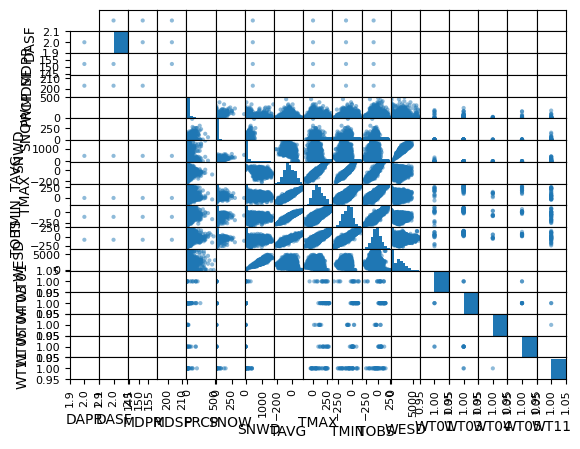

In [154]:

# numerical_vars = pivoted.select_dtypes(include=['number']).dropna()
pd.plotting.scatter_matrix(frame=pivoted,diagonal="hist")

The Scatter Matrix is messy and hard to read however, we really only need a vague idea of what the data looks like.
- Visually, There seem to be several linear relationships in the data that we may need to account for. 
- There seems to also be several columns with Few observations.

In [155]:
# Curious to see the percentage of NAN values for each variable.

percent_missing = pivoted.isnull().sum() * 100 / len(pivoted)
NA_value_percent = pd.DataFrame({"column_names": pivoted.columns, "percent_missing_value": percent_missing})
print(NA_value_percent)

         column_names  percent_missing_value
datatype                                    
station       station               0.000000
date             date               0.000000
DAPR             DAPR              99.984124
DASF             DASF              99.984124
MDPR             MDPR              99.984124
MDSF             MDSF              99.984124
PRCP             PRCP               3.794253
SNOW             SNOW              56.516907
SNWD             SNWD              48.499762
TAVG             TAVG              66.216860
TMAX             TMAX              20.098428
TMIN             TMIN              20.209557
TOBS             TOBS               4.318146
WESD             WESD              48.229878
WT01             WT01              99.745991
WT03             WT03              99.031592
WT04             WT04              99.872996
WT05             WT05              99.730116
WT11             WT11              99.428481


Most of these variables can likely be dropped since they are mostly empty anyways. 
However, this doesn't mean that they dont tell us important information. The presence of this information could mean something important...
- It might be logical to Replace the missing values with 0s or in some instances, the average of the distribution.
- Maybe the largely missing data is better represented as categorical data.

In [156]:
# Methods on Python dictionaries: https://www.w3schools.com/python/python_ref_dictionary.asp
sparse_vars = pd.Series()
counts = pd.Series()
for column in pivoted.columns:
    if len(pivoted[column].unique()) <= 10:
        sparse_vars[column] = len(pivoted[column].unique())
sparse_vars.pop("station") # Special Case we want to keep.

print(sparse_vars)


DAPR    2
DASF    2
MDPR    2
MDSF    2
WT01    2
WT03    2
WT04    2
WT05    2
WT11    2
dtype: int64


I did some quick math on the number of these non nan obsevations and based on the size of the dataframe and percent of nans,
there should be only one observation with a value for all of these variables so we will drop the columns

In [157]:
pivoted = pivoted.drop(labels=sparse_vars.keys(), axis=1)
print(pivoted.columns.tolist)

<bound method IndexOpsMixin.tolist of Index(['station', 'date', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN',
       'TOBS', 'WESD'],
      dtype='object', name='datatype')>


array([[<Axes: xlabel='PRCP', ylabel='PRCP'>,
        <Axes: xlabel='SNOW', ylabel='PRCP'>,
        <Axes: xlabel='SNWD', ylabel='PRCP'>,
        <Axes: xlabel='TAVG', ylabel='PRCP'>,
        <Axes: xlabel='TMAX', ylabel='PRCP'>,
        <Axes: xlabel='TMIN', ylabel='PRCP'>,
        <Axes: xlabel='TOBS', ylabel='PRCP'>,
        <Axes: xlabel='WESD', ylabel='PRCP'>],
       [<Axes: xlabel='PRCP', ylabel='SNOW'>,
        <Axes: xlabel='SNOW', ylabel='SNOW'>,
        <Axes: xlabel='SNWD', ylabel='SNOW'>,
        <Axes: xlabel='TAVG', ylabel='SNOW'>,
        <Axes: xlabel='TMAX', ylabel='SNOW'>,
        <Axes: xlabel='TMIN', ylabel='SNOW'>,
        <Axes: xlabel='TOBS', ylabel='SNOW'>,
        <Axes: xlabel='WESD', ylabel='SNOW'>],
       [<Axes: xlabel='PRCP', ylabel='SNWD'>,
        <Axes: xlabel='SNOW', ylabel='SNWD'>,
        <Axes: xlabel='SNWD', ylabel='SNWD'>,
        <Axes: xlabel='TAVG', ylabel='SNWD'>,
        <Axes: xlabel='TMAX', ylabel='SNWD'>,
        <Axes: xlabel='TMIN', yl

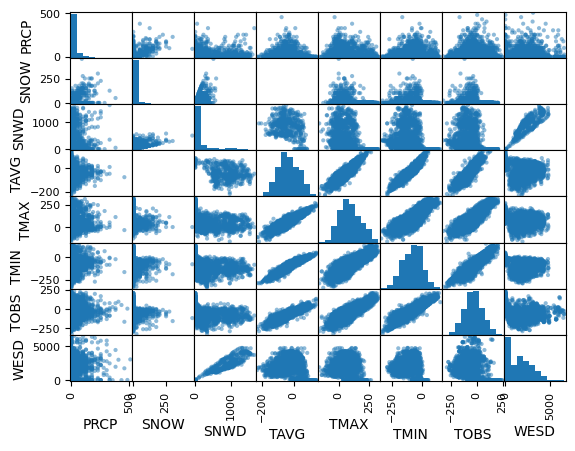

In [158]:
# new scatter matrix w/ less vars:
pd.plotting.scatter_matrix(frame=pivoted,diagonal="hist")

In [159]:
pivoted.index

RangeIndex(start=0, stop=6299, step=1)

We havent yet determined what we want to try and measure and therefor what our target variable should be. Lets start by brainstorming some questions:
1. can we predict what station a given observation came from?
2. Has precipitation declined over time in Ouray County?
3. Is there a link between precipitation and tempurature? 
4. Has The avg temp gone up over time?
5. Does the daily tempurature vary more now than it did before?

Each of these questions has an associated target variable. Lets start with question 3.

Before we do some stats, we need to clean and reduce...

We still have a lot of NAN values which we will need to address in order for PCA to work. We also need to standardize our data for the same reasons

Here are our options:
1. Imputation methods (inserting 0s or the avg or something)
2. Dropping Nan Values.

Imputation is likely the more reasonable option if we dont want to lose 60 percent of our data.

In [160]:
#still seeing a bunch of NAN: lets double check everything went ok:
percent_missing = pivoted.isnull().sum() * 100 / len(pivoted)
NA_value_percent = pd.DataFrame({"column_names": pivoted.columns, "percent_missing_value": percent_missing})
print(NA_value_percent)

         column_names  percent_missing_value
datatype                                    
station       station               0.000000
date             date               0.000000
PRCP             PRCP               3.794253
SNOW             SNOW              56.516907
SNWD             SNWD              48.499762
TAVG             TAVG              66.216860
TMAX             TMAX              20.098428
TMIN             TMIN              20.209557
TOBS             TOBS               4.318146
WESD             WESD              48.229878


In [161]:
pivoted["station"].unique()

array(['GHCND:USC00057020', 'GHCND:USS0007M27S'], dtype=object)

In [162]:
# Some variables seem like 0 could be imputed safely. (PRCP is likely precipitation and we could prob impute 0)
# We should get Descriptions of varaiables...
client = NOAAClient(timeout=30, token="vOtNXJNrfqNUgpwJdjFgYacsOlrQtKjh")
client.dtype_description_by_station(dtypes=["PRCP", "TOBS", "SNOW", "SNWD", "TAVG", "TMAX", "TMIN", "WESD"], station='GHCND:USC00057020')
client.dtype_description_by_station(dtypes=["PRCP", "TOBS", "SNOW", "SNWD", "TAVG", "TMAX", "TMIN", "WESD"], station='GHCND:USS0007M27S')


AttributeError: 'NOAAClient' object has no attribute 'dtype_description_by_station'

In [ ]:
#Standardizing  and imputing data
scaler = StandardScaler()
impute_median = SimpleImputer(missing_values=pd.NA, strategy='median') #Imputing w/ mean...
scaled = scaler.fit_transform(pivoted.drop(labels=["station", "date"],axis=1))
scaled = impute_median.fit_transform(X=scaled)
scaled = pd.DataFrame(scaled)
categorical = pd.concat([pivoted["station"], pivoted["date"]], axis=1)

pd.concat([categorical, scaled], axis=1).to_parquet(path="data/clean_imputed_data_2.parquet",index=False)

# scaled = scaled.drop(labels=["station", "date"],axis=1).columns

#to parquet bc its clean
# scaled.to_parquet(path="data/clean_imputed_data_1.parquet",index=False)
print(scaled.columns)

# target = scaled["PRCP"]
# predictors = scaled.drop(labels="PRCP", axis=1)
# print(target.head())
# print(predictors.head())



RangeIndex(start=0, stop=8, step=1)


In [ ]:
# Now we can create a covariance matrix for our data...
print(predictors.cov())

#according to documentation, NA are auto excluded so we can see what cov would be like w/o imputation..
print(pivoted.drop(labels=["station", "date", "PRCP"], axis=1).cov())

datatype          SNOW      SNWD          TAVG      TMAX      TMIN      TOBS  \
datatype                                                                       
SNOW      4.349000e-01  0.052266 -5.846901e-35 -0.101641 -0.043124 -0.062531   
SNWD      5.226609e-02  0.515084 -5.177566e-02 -0.228502 -0.189692 -0.189036   
TAVG     -5.846901e-35 -0.051776  3.378850e-01  0.247094  0.262330  0.212676   
TMAX     -1.016406e-01 -0.228502  2.470941e-01  0.799143  0.645614  0.636186   
TMIN     -4.312362e-02 -0.189692  2.623300e-01  0.645614  0.798031  0.677700   
TOBS     -6.253095e-02 -0.189036  2.126757e-01  0.636186  0.677700  0.956970   
WESD      7.104351e-34  0.123924 -5.348311e-02 -0.055455 -0.058322 -0.180796   

datatype          WESD  
datatype                
SNOW      7.104351e-34  
SNWD      1.239241e-01  
TAVG     -5.348311e-02  
TMAX     -5.545505e-02  
TMIN     -5.832214e-02  
TOBS     -1.807959e-01  
WESD      5.177834e-01  
datatype         SNOW           SNWD          TAVG    

One thing to note is that variance is defined as the covariance between a predictor and itself, therefore...
- TOBS, TMIN, and TMAX have the highest variances.


In [ ]:
# PCA TIME!
pca = PCA()
components = pca.fit_transform(predictors)
# to df
components = pd.DataFrame(components)
print(components)
#Keeps dimensionality for now... we can investigate how many components we want to keep later...

                 0             1             2             3             4  \
0     3.216412e-19 -1.616086e-17 -2.045908e-17 -2.196047e-17 -4.577771e-18   
1     3.216412e-19 -1.616086e-17 -2.045908e-17 -2.196047e-17 -4.577771e-18   
2     3.216412e-19 -1.616086e-17 -2.045908e-17 -2.196047e-17 -4.577771e-18   
3     3.216412e-19 -1.616086e-17 -2.045908e-17 -2.196047e-17 -4.577771e-18   
4     3.216412e-19 -1.616086e-17 -2.045908e-17 -2.196047e-17 -4.577771e-18   
...            ...           ...           ...           ...           ...   
6294 -1.308501e+00  1.687913e-01  4.833231e-01  7.261043e-01  8.136795e-02   
6295 -2.506883e+00 -1.027453e-01  3.325514e-01  7.322266e-01 -3.861322e-01   
6296 -1.905586e+00  5.444096e-02  3.913648e-01  8.014878e-01 -2.776567e-01   
6297 -8.447887e-01  3.185973e-01  7.889540e-01  1.075063e+00 -8.629989e-02   
6298 -2.169930e+00  2.366657e-01  5.028150e-01  8.248039e-01  1.772694e-01   

                 5             6  
0    -4.879270e-18 -1.331732

In [ ]:
#We also likely want PCA dat so were gonna convert to parquet here as well...
